# Summary
We want to run the combined pipeline on public data. Our pipeline requires two things:
1. A folder with individual signals
2. A csv file with split and signal names

## This notebook
In this notebook we take the `ptb` data, which is of length 2000, and save it in a designated folder.

## 0. Load the combined csv to see how it looks

In [2]:
import pandas as pd
import os
import numpy as np
import pickle 
from tqdm import tqdm
os.chdir('/home/david/Desktop/projects/thesis/')

import matplotlib.pyplot as plt
import seaborn as sns
from upstream_seq2seq.utils.signal_processing import resample

from combined_downstream_upstream.utils.LoadModels import *
from combined_downstream_upstream.executors.train_combined_model import trainer

raw_signals_path = './downstream_classification/data/ptb-ecg-processed-npy'
output_signals_path = './downstream_classification/data/ptb-ecg-processed-divided-into-450'


# Loading an example
files_paths = [x for x in os.listdir(raw_signals_path) if '_hr' in x]
example_signal = np.load(f'{raw_signals_path}/{files_paths[0]}')
example_signal = np.expand_dims(example_signal.T, 0)
print(f'Loaded file: {files_paths[0]}')
print('Shape:', example_signal.shape)
example_signal = resample(example_signal, original_hz=500, desired_hz=200)
print('Shape:', example_signal.shape)


def saving(input_file, output_path, window_size=450, stride = 450):
    # Get file name
    original_filename = input_file.split('/')[-1].replace('.npy','')
    
    # Load and fix shape
    raw_signal = np.load(input_file)
    raw_signal = np.expand_dims(raw_signal.T, 0) # the resampling expects (1,C,L) shaped signals

    # Resample
    raw_signal = resample(raw_signal, original_hz=500, desired_hz=200)

    # Save
    for idx,i in enumerate(range(0, raw_signal.shape[2] - window_size + 1, stride)):
        segment = raw_signal[:, :, i:i + window_size].squeeze() # the dataloader expects (C,L) shaped signals

        # Save each segment into a separate file
        filename = f"{original_filename}_{idx}.npy"

        np.save(f'{output_path}/{filename}', segment)
        # print(f'{filename}: {segment.shape}')

# for file_path in tqdm(files_paths):
    # saving(f'{raw_signals_path}/{file_path}', output_path=output_signals_path, window_size=450, stride = 350)

Loaded file: 01647_hr.npy
Shape: (1, 12, 5000)
Shape: (1, 12, 2000)


100%|██████████| 21837/21837 [01:08<00:00, 319.37it/s]


In [6]:
individual_signals = list(os.listdir(output_signals_path))
print(f'Total number of signals: {len(individual_signals)}')


Total number of signals: 109185


## Sort Medatada

In [7]:
individual_signals.sort()
individual_signals[:10]

['00001_hr_0.npy',
 '00001_hr_1.npy',
 '00001_hr_2.npy',
 '00001_hr_3.npy',
 '00001_hr_4.npy',
 '00002_hr_0.npy',
 '00002_hr_1.npy',
 '00002_hr_2.npy',
 '00002_hr_3.npy',
 '00002_hr_4.npy']

In [4]:
metadata = pd.read_csv(f'{raw_signals_path}/metadata_with_label.csv', index_col=0)
metadata

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,reading,AF,sample
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr,0,train
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr,0,validation
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,00003_hr,0,test
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,00004_hr,0,train
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,00005_hr,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,21833_hr,0,validation
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,21834_hr,0,test
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,21835_hr,0,validation
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,21836_hr,0,validation


In [12]:
# Function to generate duplicated rows with suffixes
def duplicate_rows_with_suffix(df, n):
    # Create a list to store the new rows
    new_rows = []
    
    # Iterate through each row
    for _, row in df.iterrows():
        # Create 'n' new rows for each original row
        for i in range(n + 1):  # range(n+1) to include _0
            new_row = row.copy()
            new_row['reading'] = f"{row['reading']}_{i}"
            new_rows.append(new_row)
    
    # Convert the list of new rows into a new dataframe
    new_df = pd.DataFrame(new_rows)
    return new_df

# Apply the function (change 5 to the desired number of duplicates)
new_df = duplicate_rows_with_suffix(metadata,4)
new_df.iloc[:20]

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,reading,AF,sample
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr_0,0,train
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr_1,0,train
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr_2,0,train
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr_3,0,train
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr_4,0,train
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr_0,0,validation
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr_1,0,validation
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr_2,0,validation
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr_3,0,validation
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr_4,0,validation


In [10]:
metadata.iloc[:5]

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,reading,AF,sample
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,00001_hr,0,train
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,00002_hr,0,validation
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,00003_hr,0,test
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,00004_hr,0,train
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,00005_hr,0,test


In [14]:
metadata.shape, new_df.shape, metadata.shape[0]/new_df.shape[0]

((21837, 31), (109185, 31), 0.2)

In [15]:
# new_df.to_csv(f'./downstream_classification/data/combined_data/ptb_signal_level_metadata_with_label.csv')

# Checking Private Signals, for comparisson

(12, 450)


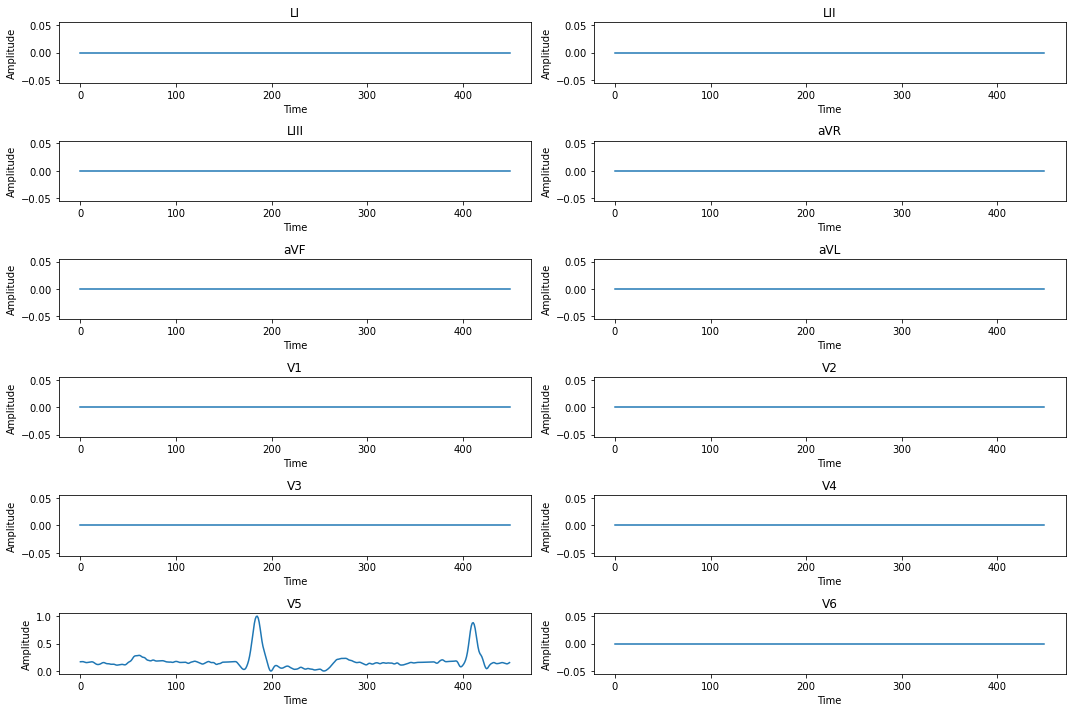

In [24]:
private_files_path = './downstream_classification/data/individual-signals-registered/'
private_files_for_comparison = os.listdir('./downstream_classification/data/individual-signals-registered/')[:10]
example_signal = np.load(f'{private_files_path}/{private_files_for_comparison[0]}')
print(example_signal.shape)

leads = ['LI', 'LII', 'LIII', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Create a 6x2 subplot
fig, axes = plt.subplots(6, 2, figsize=(15, 10))

# Plot each lead in the appropriate subplot
for i in range(12):
    row, col = divmod(i, 2)  # Determine the subplot position
    axes[row, col].plot(example_signal[i, :])
    axes[row, col].set_title(f'{leads[i]}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

